In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Trajectory import Trajectory

In [2]:
dcd_superdir = '/home/gridsan/gschuette/binz_group_shared/gkks/with_Amogh/40_Bead_systems/fully_connected_40_bead_PLM_only/LAMMPS_Files/'
gaussian_chain_f = dcd_superdir + 'gaussian_chain/DUMP_FILE.dcd'
e03_f = dcd_superdir + 'run_e0.3/DUMP_FILE.dcd'
e035_f = dcd_superdir + 'run_e0.35/DUMP_FILE.dcd'
e04_f = dcd_superdir + 'run_e0.4/DUMP_FILE.dcd'
e1_f = dcd_superdir + 'run_e1.0/DUMP_FILE.dcd'

num_dcd_beads = 500
num_beads_to_analyze = 64

In [3]:
def load_lammps_trajectory(fp,num_dcd_beads=num_dcd_beads,num_beads_to_analyze=num_beads_to_analyze):
    bead_start = (num_dcd_beads - num_beads_to_analyze)//2
    bead_stop = bead_start + num_beads_to_analyze

    return Trajectory.from_dcd(fp,num_beads=num_dcd_beads)[:,bead_start:bead_stop,:]

In [4]:
def plot_CD(conformations,loop_size1=25,second_loop_size=15,r_c=1.5,fig=None,ax=None,title_end=''):

    contacts = (conformations.distances.values < r_c).float()

    # Base loop
    i1,j1 = 0,loop_size1
    Ls = []
    corrs = []
    while j1 < contacts.shape[-1]:
        base = contacts[:,i1,j1]
        base_mean = base.mean()

        # Secondary loops
        i2,j2 = 0,second_loop_size
        while j2 < contacts.shape[-1]:
            secondary = contacts[:,i2,j2]
            Ls.append(j2 - j1)
            corrs.append( (secondary*base).mean()/( base_mean * secondary.mean() ) )
            i2+=1
            j2+=1
        i1+=1
        j1+=1

    Ls = torch.tensor(Ls)
    corrs = torch.tensor(corrs)

    Ls2 = Ls.unique()
    corrs2 = []
    for L in Ls2:
        corrs2.append( corrs[Ls==L].mean() )

    Ls = Ls2
    corrs = torch.tensor(corrs2)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.plot(Ls,corrs)
    ax.set_xlabel('L')
    ax.set_ylabel('Chan/Dill correlation')

    ax.set_title(f'Contact correlation, loop sizes {loop_size1} and {second_loop_size}'+title_end)

    return fig, ax
    
        
    
    

In [5]:
def plot_my_corr(conformations,loop_size1=25,second_loop_size=15,r_c=1.5,fig=None,ax=None,title_end=''):

    contacts = conformations.distances.values

    # Base loop
    i1,j1 = 0,loop_size1
    Ls = []
    corrs = []
    while j1 < contacts.shape[-1]:
        base = contacts[:,i1,j1]
        base_mean = base.mean()

        # Secondary loops
        i2,j2 = 0,second_loop_size
        while j2 < contacts.shape[-1]:
            secondary = contacts[:,i2,j2]
            Ls.append(j2 - j1)
            corrs.append( (secondary*base).mean()/( base_mean * secondary.mean() ) )
            i2+=1
            j2+=1
        i1+=1
        j1+=1

    Ls = torch.tensor(Ls)
    corrs = torch.tensor(corrs)

    Ls2 = Ls.unique()
    corrs2 = []
    for L in Ls2:
        corrs2.append( corrs[Ls==L].mean() )

    Ls = Ls2
    corrs = torch.tensor(corrs2)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.plot(Ls,corrs)
    ax.set_xlabel('L')
    ax.set_ylabel('$\\frac{<d_i d_j>}{<d_i><d_j>}$')

    ax.set_title(f'Distance correlation, loop sizes {loop_size1} and {second_loop_size}'+title_end)

    return fig, ax
    
        
    
    

In [6]:
def plot_pcc(conformations,loop_size1=25,second_loop_size=15,r_c=1.5,fig=None,ax=None,title_end=''):

    contacts = conformations.distances.values

    # Base loop
    i1,j1 = 0,loop_size1
    Ls = []
    corrs = []
    while j1 < contacts.shape[-1]:
        base = contacts[:,i1,j1]
        
        # Secondary loops
        i2,j2 = 0,second_loop_size
        while j2 < contacts.shape[-1]:
            secondary = contacts[:,i2,j2]
            Ls.append(j2 - j1)
            corrs.append( torch.corrcoef(torch.stack([base,secondary],dim=0))[0,1] )
            i2+=1
            j2+=1
        i1+=1
        j1+=1

    Ls = torch.tensor(Ls)
    corrs = torch.tensor(corrs)

    Ls2 = Ls.unique()
    corrs2 = []
    for L in Ls2:
        corrs2.append( corrs[Ls==L].mean() )

    Ls = Ls2
    corrs = torch.tensor(corrs2)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.plot(Ls,corrs)
    ax.set_xlabel('L')
    ax.set_ylabel('PCC')

    ax.set_title(f'Distance correlation, loop sizes {loop_size1} and {second_loop_size}'+title_end)

    return fig, ax
    
        
    
    

In [7]:
sys.path.insert(1,'../../code/data_utils/')
from ConfigDataset import ConfigDataset

config_fp = '../../data/processed_data.hdf5'
mean_dist_fp = '../../data/mean_dists.pt'
mean_sq_dist_fp='../../data/squares.pt'

config_ds = ConfigDataset(
    config_fp,
    segment_length=64,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,
    replicates=None,
    shuffle=False,
    allow_overlap=False,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)

tan_configs = []
tan_configs1 = []
s = config_ds.start_indices
for i in range(64):
    tan_configs.append(config_ds.coords[s+i,:3])
    tan_configs1.append(config_ds.coords[s+i,3:])

tan_configs = Coordinates(
    torch.cat(
        [
            torch.stack(tan_configs,dim=1),
            torch.stack(tan_configs1,dim=1)
        ],
        dim=0
    )
)
del tan_configs1,s

In [13]:
gen = Coordinates(torch.load('../../data/samples/origami_64_no_embed_reduction/eval_mode/corrected/unguided.pt'))
gc = load_lammps_trajectory(gaussian_chain_f)
e3 = load_lammps_trajectory(e03_f)
e35 = load_lammps_trajectory(e035_f)
e4 = load_lammps_trajectory(e04_f)
e1 = load_lammps_trajectory(e1_f)

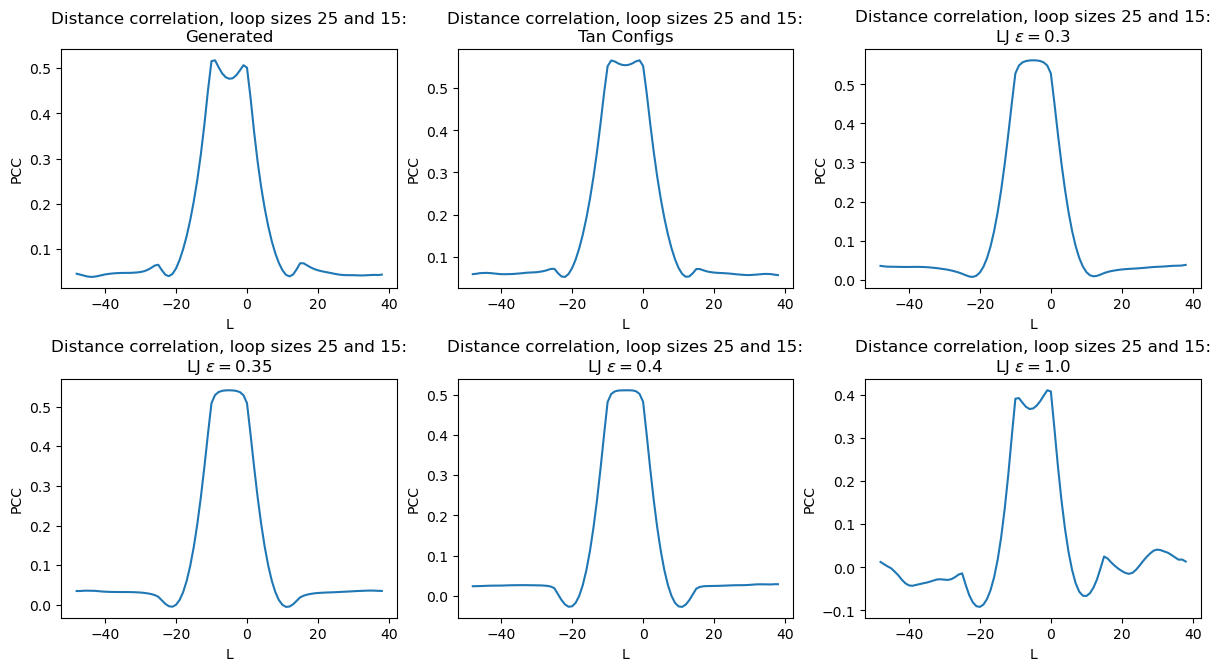

In [16]:
loop_size1 = 25
loop_size2 = 15
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(12,6.6),layout="constrained")

for c,t,ax in [(gen,':\nGenerated',ax1),(tan_configs,':\nTan Configs',ax2),(e3,':\nLJ $\\epsilon=0.3$',ax3),(e35,':\nLJ $\\epsilon=0.35$',ax4),
               (e4,':\nLJ $\\epsilon=0.4$',ax5),(e1,':\nLJ $\\epsilon=1.0$',ax6)]:

    plot_pcc(c,loop_size1=loop_size1,second_loop_size=loop_size2,title_end=t,ax=ax)

In [ ]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(12,6.6),layout="constrained")

for c,t,ax in [(gen,':\nGenerated',ax1),(gc,':\nGaussian Chain',ax2),(e3,':\nLJ $\\epsilon=0.3$',ax3),(e35,':\nLJ $\\epsilon=0.35$',ax4),
               (e4,':\nLJ $\\epsilon=0.4$',ax5),(e1,':\nLJ $\\epsilon=1.0$',ax6)]:

    plot_CD(c,title_end=t,ax=ax)

In [ ]:
loop_size1 = 15
loop_size2 = 10
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(12,6.6),layout="constrained")

for c,t,ax in [(gen,':\nGenerated',ax1),(gc,':\nGaussian Chain',ax2),(e3,':\nLJ $\\epsilon=0.3$',ax3),(e35,':\nLJ $\\epsilon=0.35$',ax4),
               (e4,':\nLJ $\\epsilon=0.4$',ax5),(e1,':\nLJ $\\epsilon=1.0$',ax6)]:

    plot_CD(c,loop_size1=loop_size1,second_loop_size=loop_size2,title_end=t,ax=ax)

In [ ]:
loop_size1 = 15
loop_size2 = 10
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(12,6.6),layout="constrained")

for c,t,ax in [(gen,':\nGenerated',ax1),(gc,':\nGaussian Chain',ax2),(e3,':\nLJ $\\epsilon=0.3$',ax3),(e35,':\nLJ $\\epsilon=0.35$',ax4),
               (e4,':\nLJ $\\epsilon=0.4$',ax5),(e1,':\nLJ $\\epsilon=1.0$',ax6)]:

    plot_my_corr(c,loop_size1=loop_size1,second_loop_size=loop_size2,title_end=t,ax=ax)

In [ ]:
loop_size1 = 15
loop_size2 = 10
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(12,6.6),layout="constrained")

for c,t,ax in [(gen,':\nGenerated',ax1),(gc,':\nGaussian Chain',ax2),(e3,':\nLJ $\\epsilon=0.3$',ax3),(e35,':\nLJ $\\epsilon=0.35$',ax4),
               (e4,':\nLJ $\\epsilon=0.4$',ax5),(e1,':\nLJ $\\epsilon=1.0$',ax6)]:

    plot_pcc(c,loop_size1=loop_size1,second_loop_size=loop_size2,title_end=t,ax=ax)

In [8]:
gen = Coordinates(torch.load('../../data/samples/origami_64_no_embed_reduction/eval_mode/corrected/unguided.pt'))

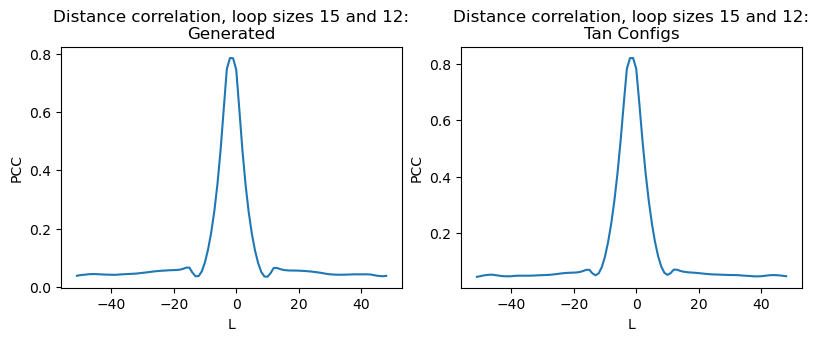

In [12]:
loop_size1 = 15
loop_size2 = 12
fig,(ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8,3.3),layout="constrained")

for c,t,ax in [(gen,':\nGenerated',ax1),(tan_configs,':\nTan Configs',ax2)]:

    plot_pcc(c[:100_000],loop_size1=loop_size1,second_loop_size=loop_size2,title_end=t,ax=ax)

In [10]:
tan_configs.shape

torch.Size([196912, 64, 3])

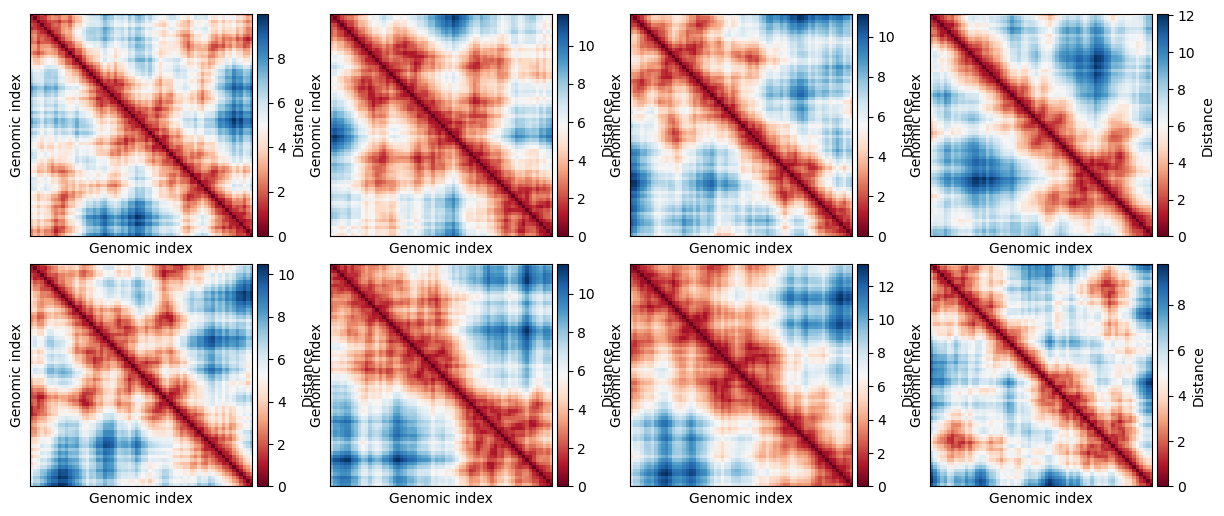

In [25]:

fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(12,5),layout="constrained")
for i in [0,1,2,3,4,5,6,7]:
    ax = axes[i//4][i%4]
    e3[i].distances.plot(fig=fig,ax=ax)

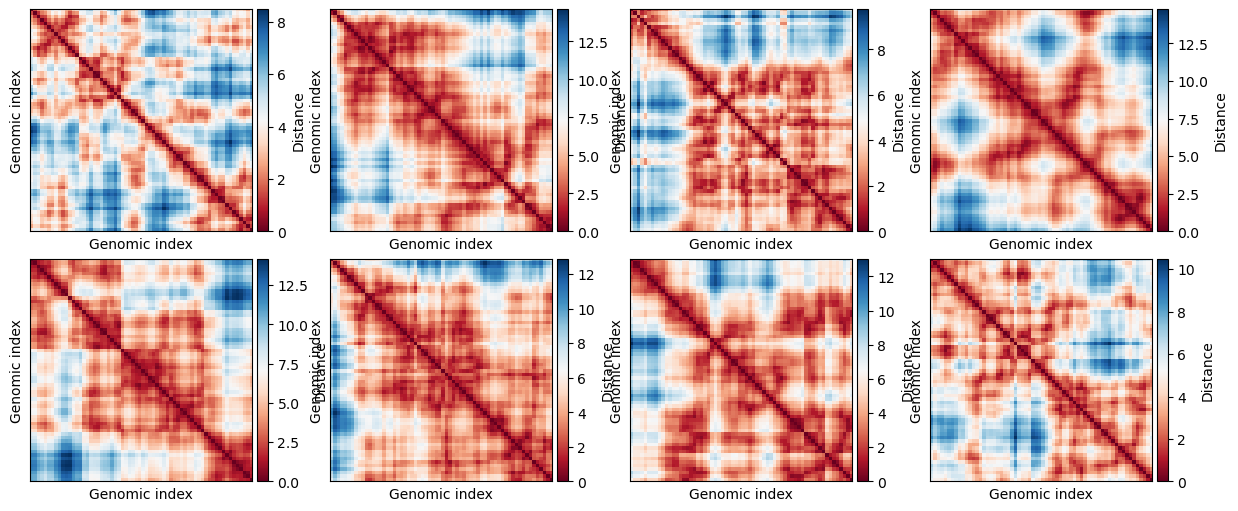

In [26]:

fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(12,5),layout="constrained")
for i in [0,1,2,3,4,5,6,7]:
    ax = axes[i//4][i%4]
    gen[i].distances.plot(fig=fig,ax=ax)

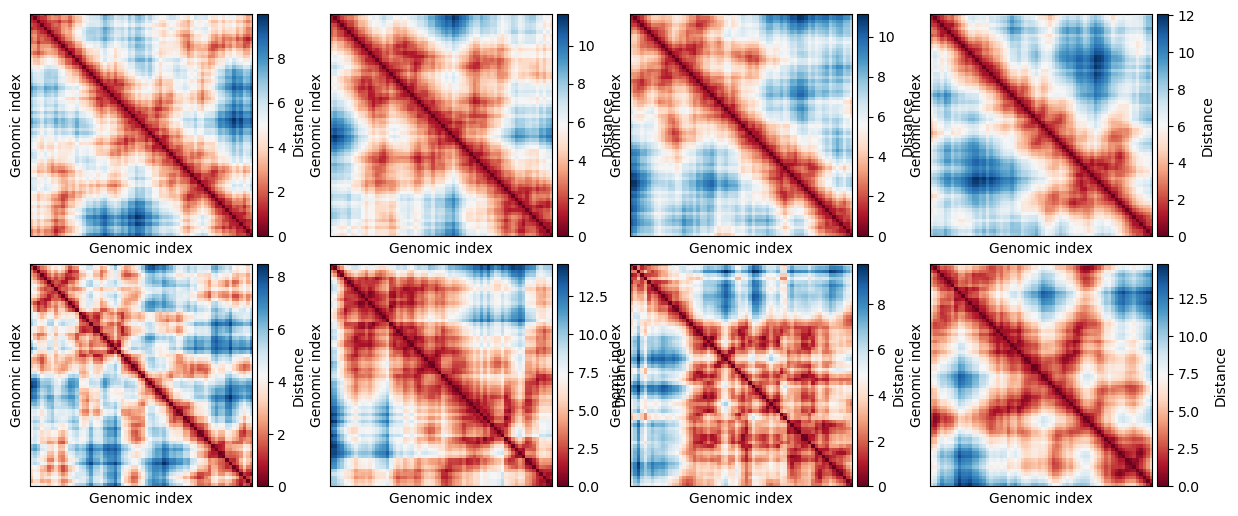

In [29]:

fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(12,5),layout="constrained")
for i in range(4):
    ax = axes[0][i%4]
    e3[i].distances.plot(fig=fig,ax=ax)
    
    ax = axes[1][i%4]
    gen[i].distances.plot(fig=fig,ax=ax)

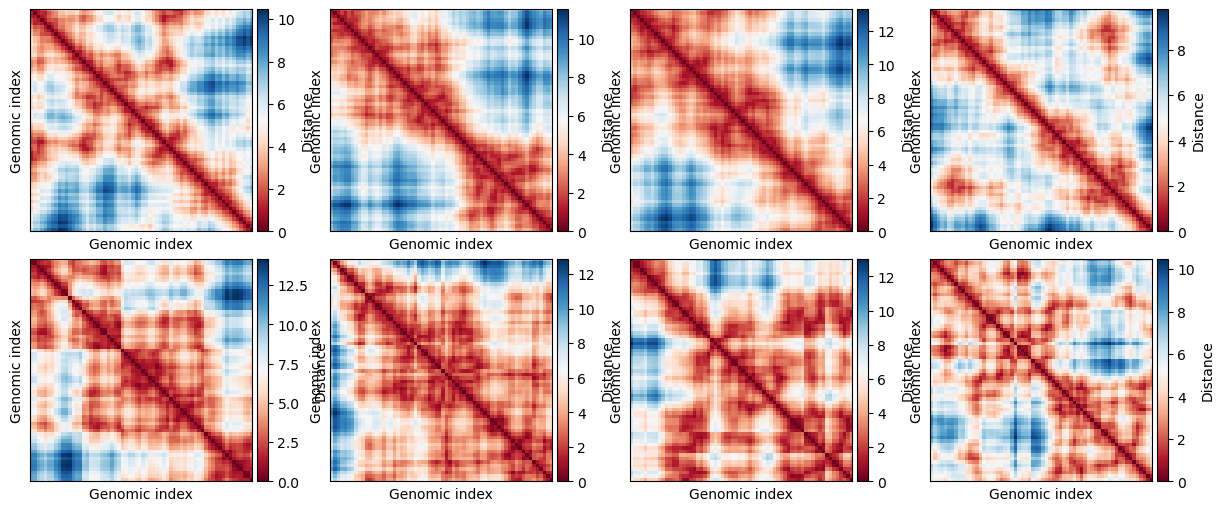

In [30]:

fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(12,5),layout="constrained")
for i in range(4,8):
    ax = axes[0][i%4]
    e3[i].distances.plot(fig=fig,ax=ax)
    
    ax = axes[1][i%4]
    gen[i].distances.plot(fig=fig,ax=ax)

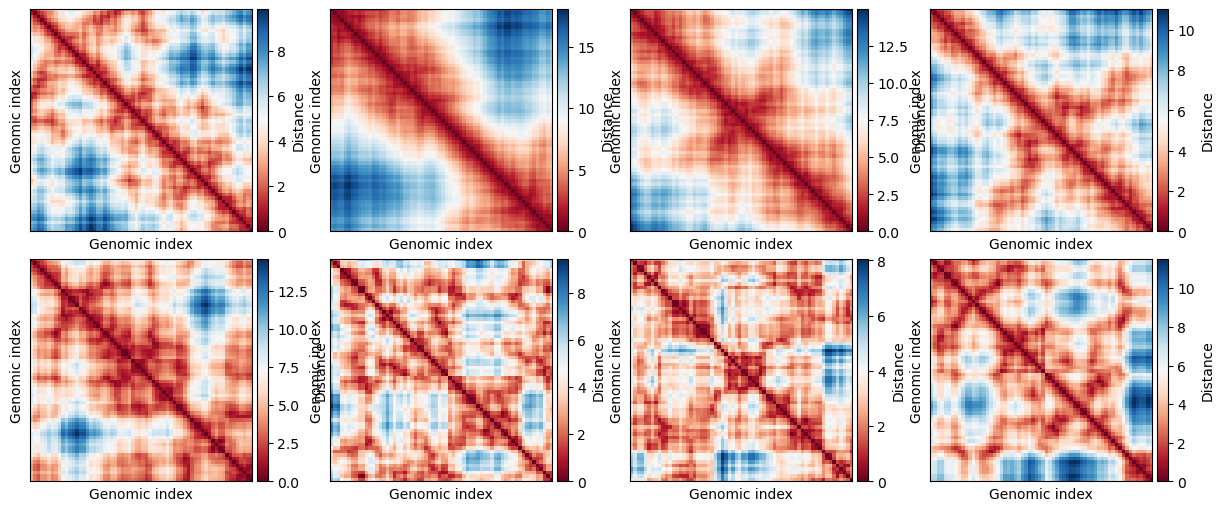

In [31]:

fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(12,5),layout="constrained")
for i in range(8,12):
    ax = axes[0][i%4]
    e3[i].distances.plot(fig=fig,ax=ax)
    
    ax = axes[1][i%4]
    gen[i].distances.plot(fig=fig,ax=ax)

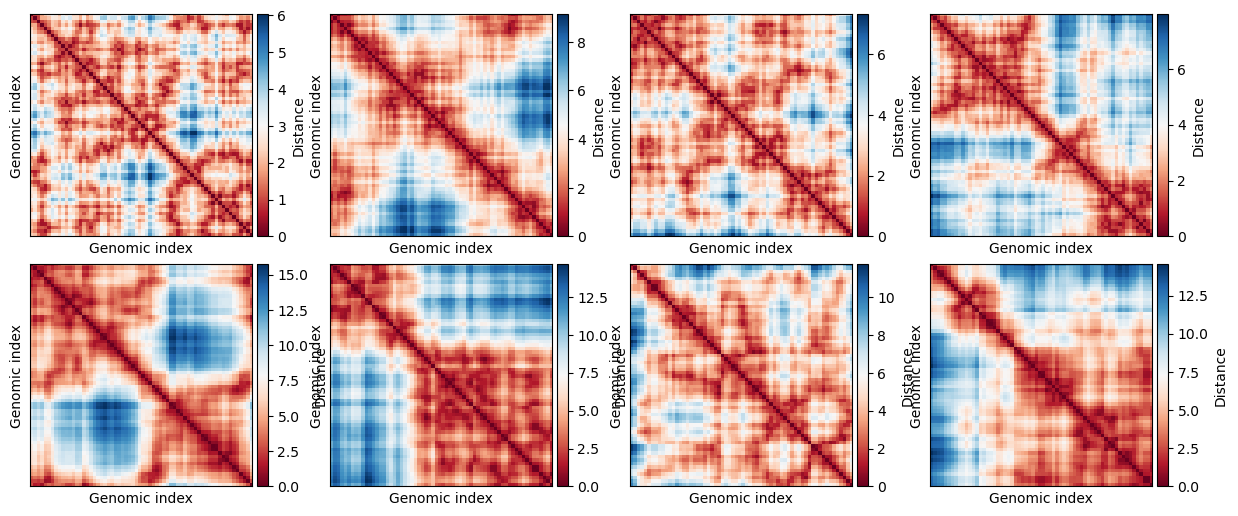

In [40]:

fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(12,5),layout="constrained")
for i,ii in enumerate(range(1000,2000,250)):
    ax = axes[0][i%4]
    gc[ii].distances.plot(fig=fig,ax=ax)
    
    ax = axes[1][i%4]
    gen[ii].distances.plot(fig=fig,ax=ax)

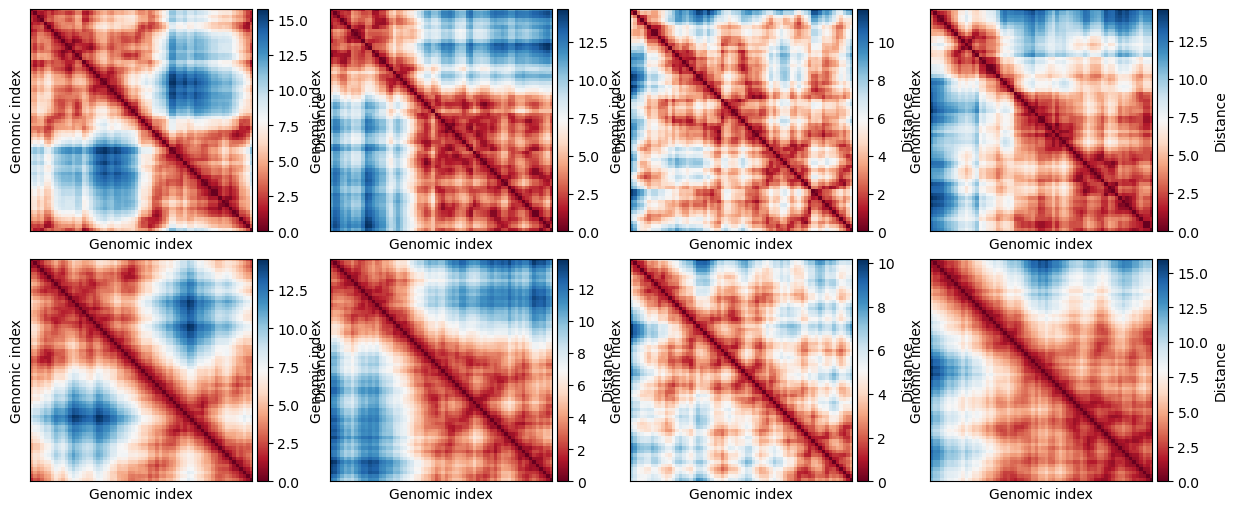

In [45]:
fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(12,5),layout="constrained")
d = e35.distances

for i,ii in enumerate(range(1000,2000,250)):
    dd = gen[ii].distances

    sse = (d.values - dd.values).square().sum(-1).sum(-1)
    iii = torch.where(sse == sse.min())[0]

    ax = axes[0][i]
    dd.plot(fig=fig,ax=ax)

    ax = axes[1][i]
    e35[iii].distances.plot(fig=fig,ax=ax)
    

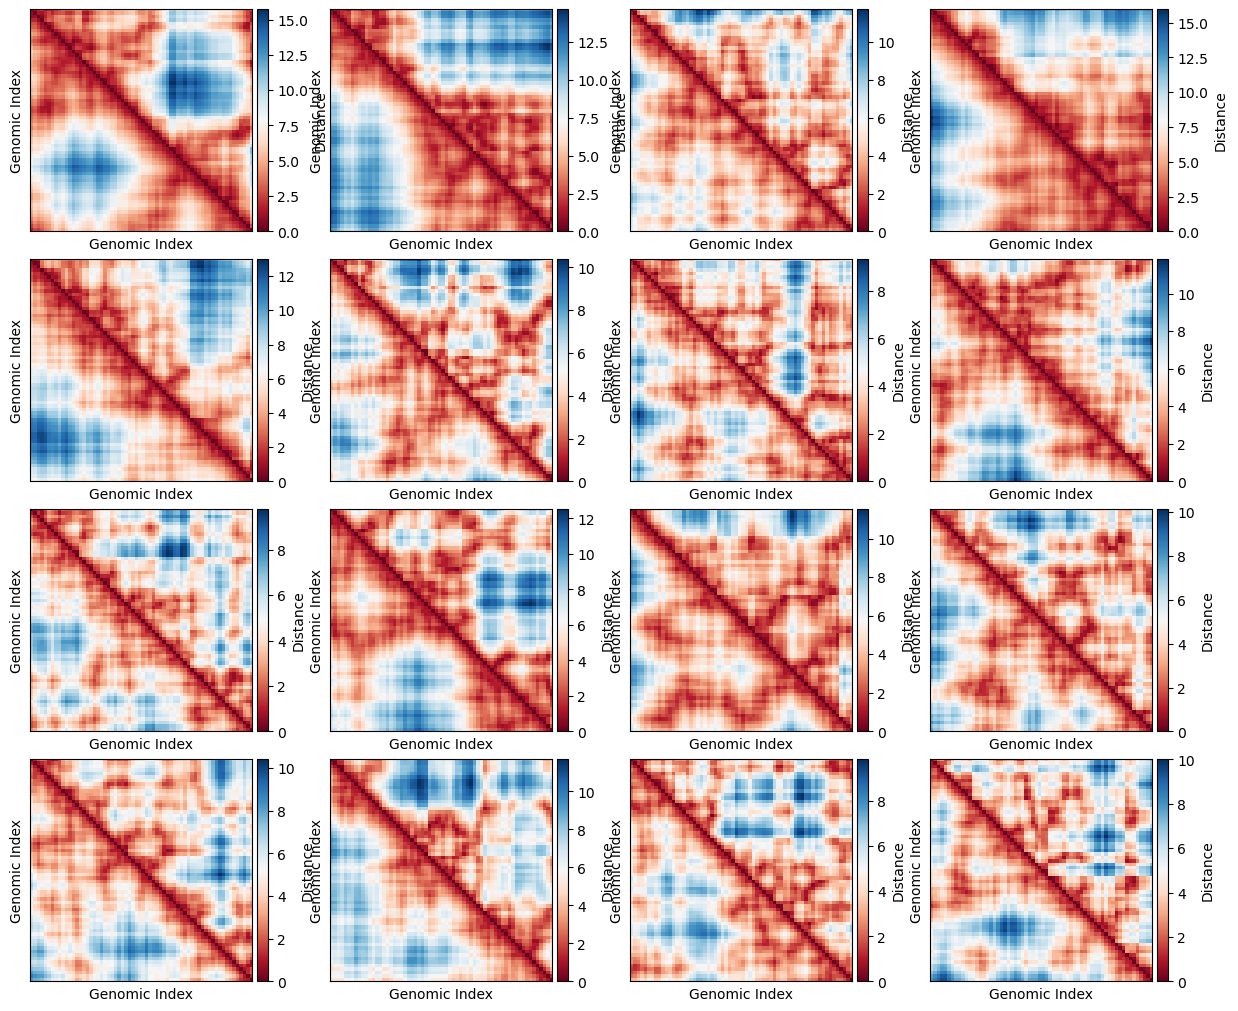

In [47]:
fig,axes = plt.subplots(ncols=4, nrows=4, figsize=(12,10),layout="constrained")
d = e35.distances

for i,ii in enumerate(range(1000,5000,250)):
    dd = gen[ii].distances

    sse = (d.values - dd.values).square().sum(-1).sum(-1)
    iii = torch.where(sse == sse.min())[0]

    ax = axes[i//4][i%4]
    dd.plot_with(e35[iii].distances,fig=fig,ax=ax)

    

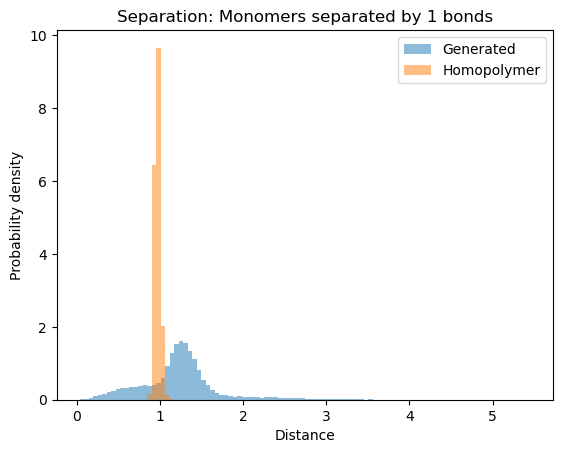

In [63]:
n = gen.num_beads
d = 1
genn = gen[:1_000].distances.values[:,range(n-d),range(d,n)].flatten()
homo = e35[:1_000].distances.values[:,range(n-d),range(d,n)].flatten()

vmin = min(genn.min(),homo.min())
vmax = max(genn.max(),homo.max())
delta = (vmax-vmin)/100
bins = torch.arange(vmin,vmax+delta/2,delta)

plt.hist(genn,density=True,label='Generated',bins=bins,alpha=.5)
plt.hist(homo,density=True,label='Homopolymer',bins=bins,alpha=.5)
plt.xlabel('Distance')
plt.ylabel('Probability density')
plt.title(f'Separation: Monomers separated by {d} bonds')
plt.legend()

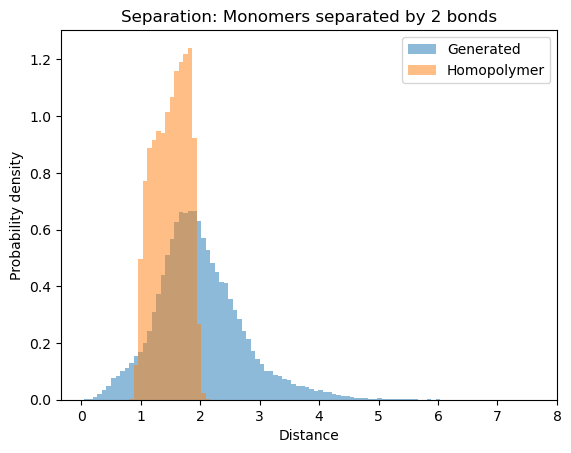

In [64]:
n = gen.num_beads
d = 2
genn = gen[:1_000].distances.values[:,range(n-d),range(d,n)].flatten()
homo = e35[:1_000].distances.values[:,range(n-d),range(d,n)].flatten()

vmin = min(genn.min(),homo.min())
vmax = max(genn.max(),homo.max())
delta = (vmax-vmin)/100
bins = torch.arange(vmin,vmax+delta/2,delta)

plt.hist(genn,density=True,label='Generated',bins=bins,alpha=.5)
plt.hist(homo,density=True,label='Homopolymer',bins=bins,alpha=.5)
plt.xlabel('Distance')
plt.ylabel('Probability density')
plt.title(f'Separation: Monomers separated by {d} bonds')
plt.legend()

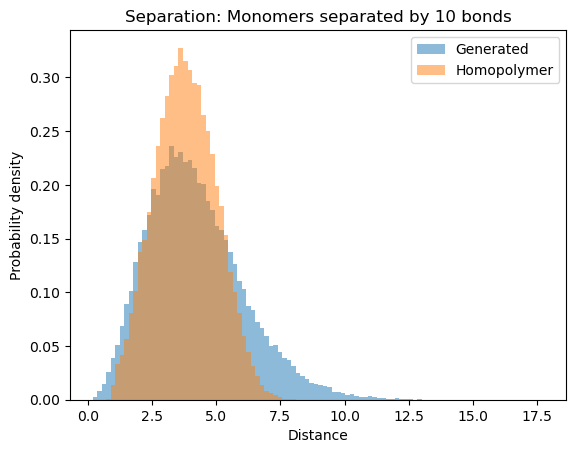

In [65]:
n = gen.num_beads
d = 10
genn = gen[:1_000].distances.values[:,range(n-d),range(d,n)].flatten()
homo = e35[:1_000].distances.values[:,range(n-d),range(d,n)].flatten()

vmin = min(genn.min(),homo.min())
vmax = max(genn.max(),homo.max())
delta = (vmax-vmin)/100
bins = torch.arange(vmin,vmax+delta/2,delta)

plt.hist(genn,density=True,label='Generated',bins=bins,alpha=.5)
plt.hist(homo,density=True,label='Homopolymer',bins=bins,alpha=.5)
plt.xlabel('Distance')
plt.ylabel('Probability density')
plt.title(f'Separation: Monomers separated by {d} bonds')
plt.legend()

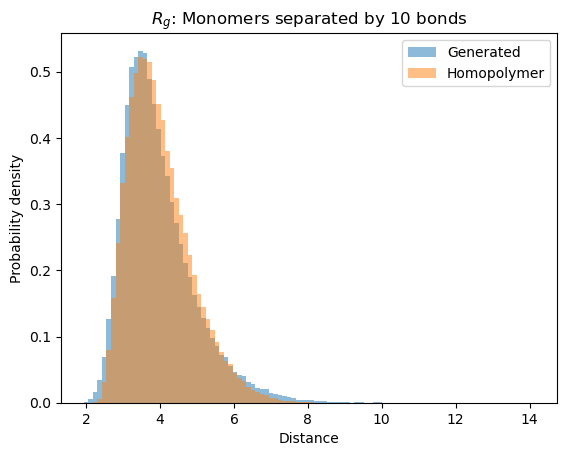

In [59]:
genn = gen.trajectory.compute_rg()
homo = e35.trajectory.compute_rg()

vmin = min(genn.min(),homo.min())
vmax = max(genn.max(),homo.max())
delta = (vmax-vmin)/100
bins = torch.arange(vmin,vmax+delta/2,delta)

plt.hist(genn,density=True,label='Generated',bins=bins,alpha=.5)
plt.hist(homo,density=True,label='Homopolymer',bins=bins,alpha=.5)
plt.xlabel('Distance')
plt.ylabel('Probability density')
plt.title(f'$R_g$: Monomers separated by {d} bonds')
plt.legend()

In [ ]:
load_lammps_trajectory('/home/gridsan/gschuette/IdealChain/script/data/dcd/run00')